In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from src import image_metrics, io_utils, image_utils
from src.Tile import Tile

# Filtering by symmetry

In this notebook I check that images are symmetric diagonally in any directions for whole image and it's middle part. I ask for at least one 2 of symmetry measures (as defined in the notebook below) to be more than threshold.

I defined metrics to be from 0 to 1, with 1 being more symmetric.

To be fair to all images, before checking their symmetry I crop them, resize them to the same size, and increase their contrast in the most contrast colour channel using functions defined in `src.image_utils`.

With this criteria I filter out some of the good images, but my goal is to make the end result of a good quality, and losing sample size is a sacrifice I am willing to make.

I tried checking image's horizontal and vertical symmetry in addition to diagonal, but didn't like the results aesthetically with images with strong horizontal or vertical symmetry.

Diagonal symmetry on it's own also wasn't enough, as images with symmetrical "borders" and assymetrical "centres" were exceed theing the threshold, so I started checking middle part of the image separately.

In [4]:
folder_list = [
    'dataset/google/azulejo',
    'dataset/google/portuguese tiles',
    'dataset/bing/azulejo',
    'dataset/bing/hand painted tile',
    'dataset/bing/handmade tile',
    'dataset/bing/portuguese tile'
]

In [5]:
from skimage.metrics import structural_similarity as ssim, normalized_root_mse

def similarity_mse_based(x, y): return 1 - normalized_root_mse(x, y)
def similarity_ssim_based(x, y): return ssim(x, y, multichannel=True)

metrics = [similarity_mse_based, similarity_ssim_based]

Working on dataset/google/azulejo folder.
Symmetries of the images


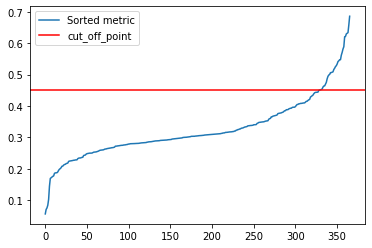

Symmetries of the images' center parts


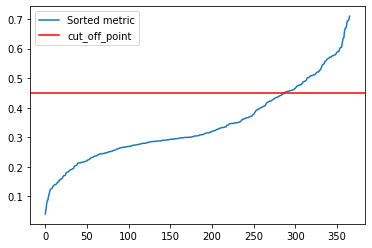

Random sample of not symmetric files:


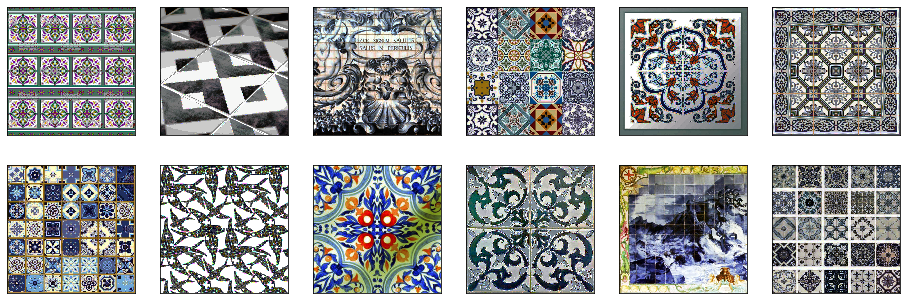

Random sample of symmetric files:


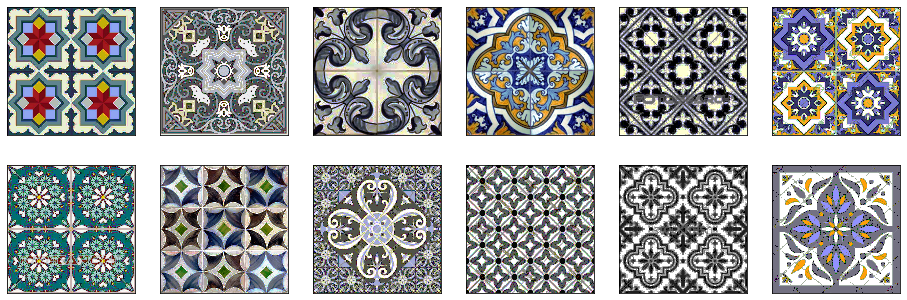

Total files: 366, out of them symmetric: 26.



Working on dataset/google/portuguese tiles folder.
Symmetries of the images


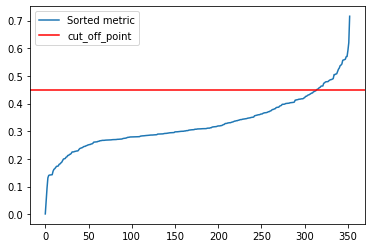

Symmetries of the images' center parts


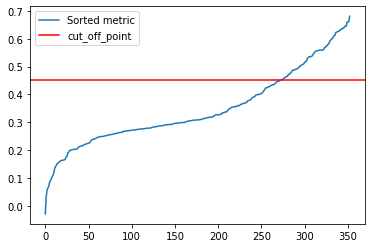

Random sample of not symmetric files:


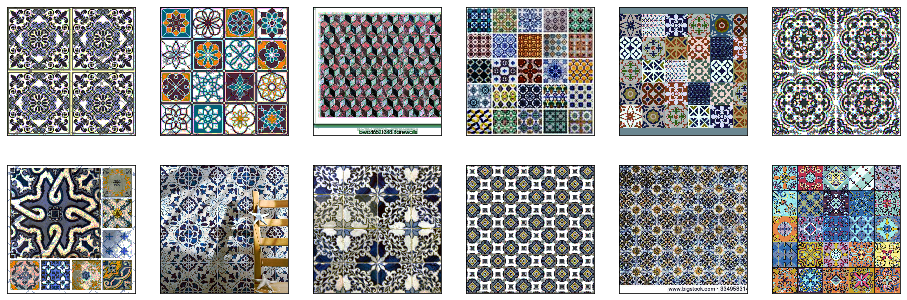

Random sample of symmetric files:


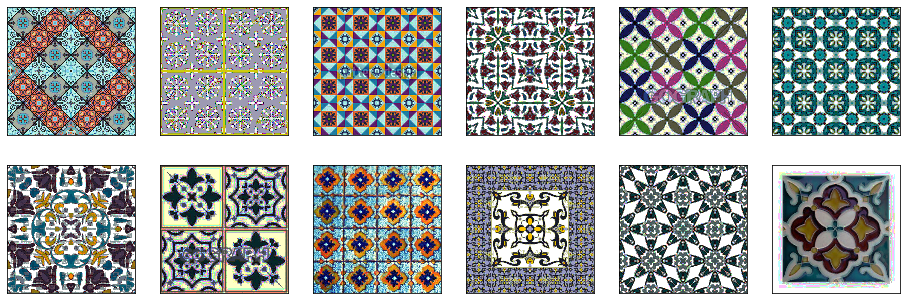

Total files: 353, out of them symmetric: 25.



Working on dataset/bing/azulejo folder.
Symmetries of the images


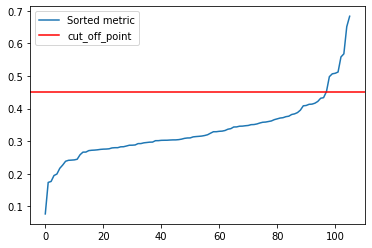

Symmetries of the images' center parts


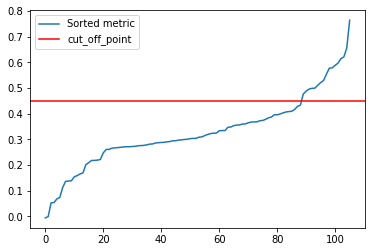

Random sample of not symmetric files:


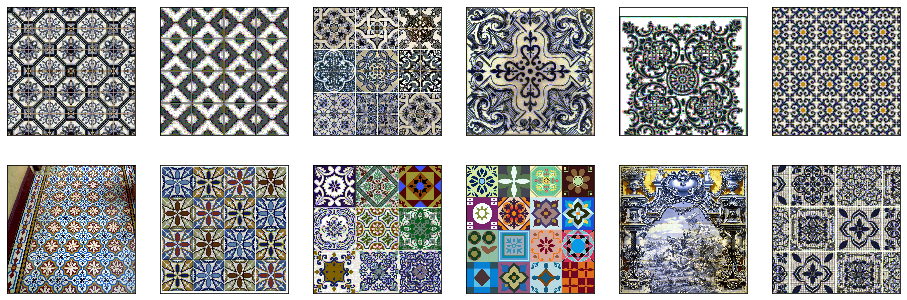

Random sample of symmetric files:


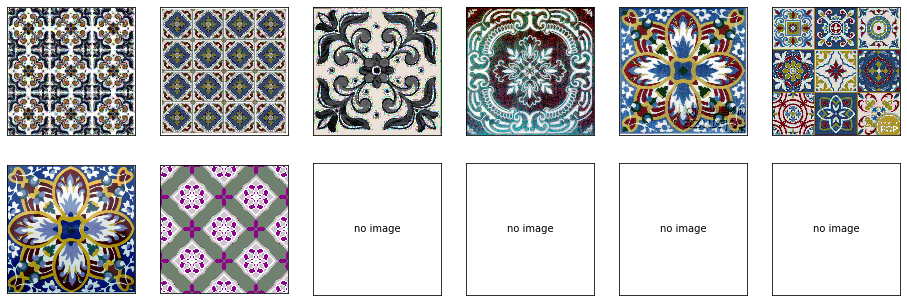

Total files: 106, out of them symmetric: 8.



Working on dataset/bing/hand painted tile folder.
Symmetries of the images


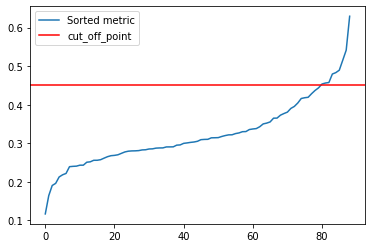

Symmetries of the images' center parts


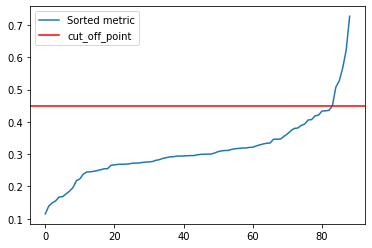

Random sample of not symmetric files:


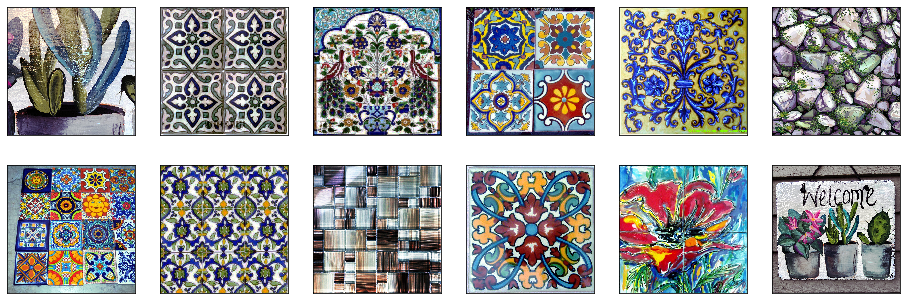

Random sample of symmetric files:


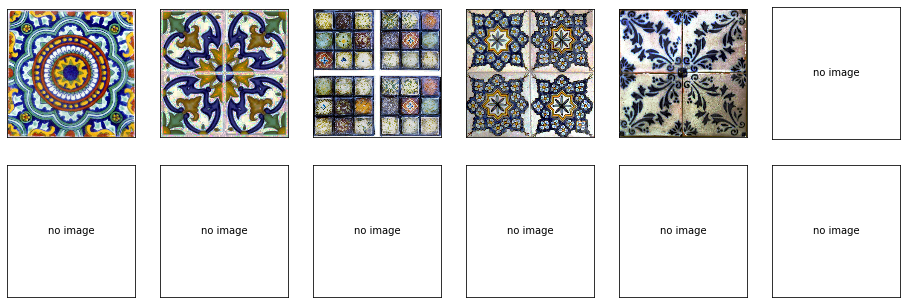

Total files: 89, out of them symmetric: 5.



Working on dataset/bing/handmade tile folder.
Symmetries of the images


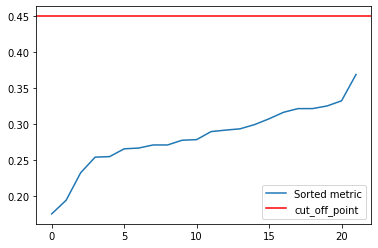

Symmetries of the images' center parts


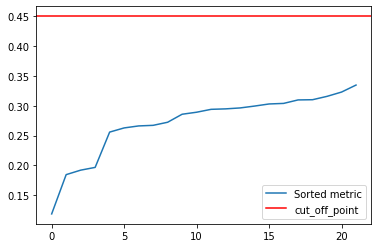

Random sample of not symmetric files:


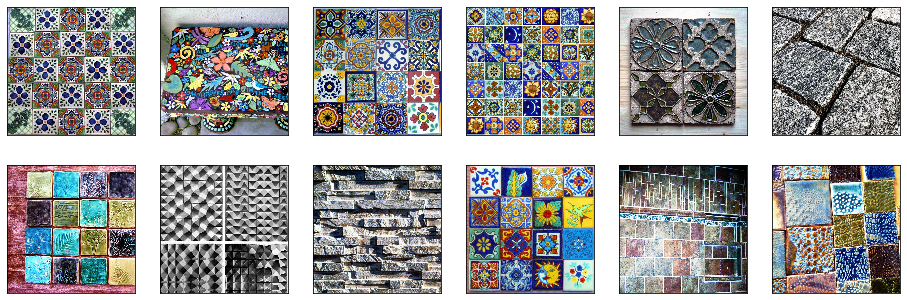

Random sample of symmetric files:


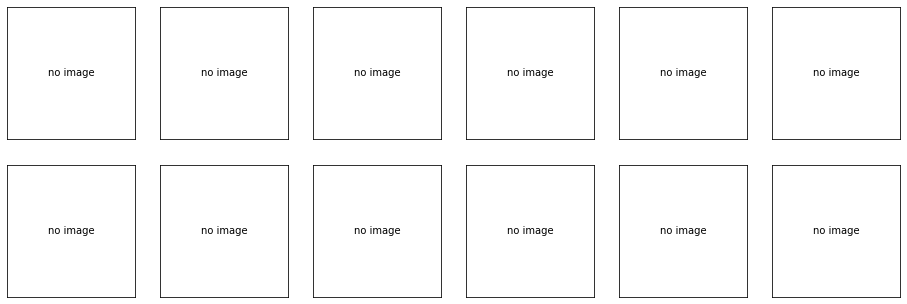

Total files: 22, out of them symmetric: 0.



Working on dataset/bing/portuguese tile folder.
Symmetries of the images


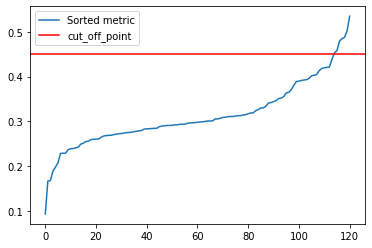

Symmetries of the images' center parts


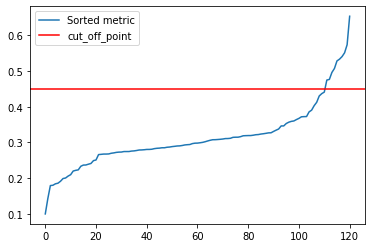

Random sample of not symmetric files:


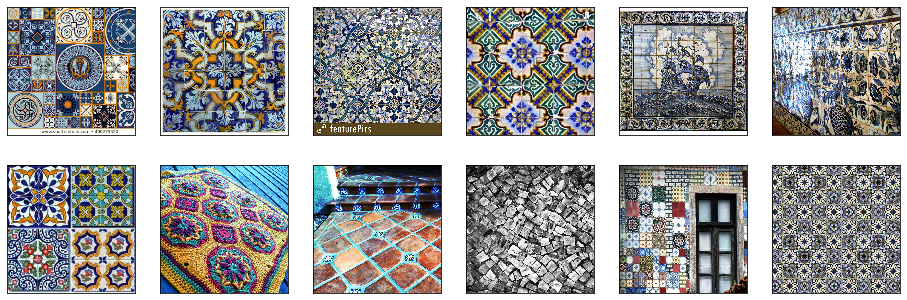

Random sample of symmetric files:


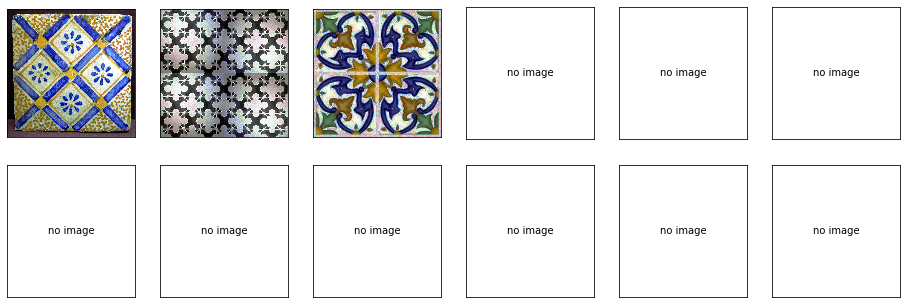

Total files: 121, out of them symmetric: 3.





In [9]:
plot_sample = 12
cut_off = 0.45

def prepare(img): return image_utils.prepare(
    img, 
    resize=True, new_size=(128, 128), 
    apply_contrast=True, 
    apply_blur=False
)

for folder in folder_list:
    print('Working on {} folder.'.format(folder))
    files = [_.strip() for _ in open('lists/contrasting_{}.txt'.format(folder.replace('/', '-')), 'r').readlines()]
    
    imgs = [
        img 
        for img 
        in io_utils.read_imgs(files, folder)
    ]
    tiles = [Tile(prepare(img)) for img in imgs]
    
    imgs_center = [
        Tile(image_utils.crop(img)).get_square_from_center(0.33).img 
        for img 
        in io_utils.read_imgs(files, folder)
    ]
    tiles_center = [Tile(prepare(img)) for img in imgs_center]
    
    symmetries = [
        max([
            image_metrics.tile_symmetry(tile, metric, min)
            for metric 
            in metrics
        ]) 
        for tile 
        in tiles
    ]
    symmetries_center = [
        max([
            image_metrics.tile_symmetry(tile, metric, min) 
            for metric 
            in metrics
        ])
        for tile 
        in tiles_center
    ]

    
    print('Symmetries of the images')
    io_utils.plot_metric(symmetries, cut_off)
    
    print('Symmetries of the images\' center parts')
    io_utils.plot_metric(symmetries_center, cut_off)
    
    files_symmetric = [
        file
        for (file, symmetry, symmetry_center)
        in zip(files, symmetries, symmetries_center) 
        if (symmetry >= cut_off) and (symmetry_center >= cut_off)
    ]
    imgs_symmetric = [prepare(img) for img in io_utils.read_imgs(files_symmetric, folder)]
    
    files_other = [_ for _ in files if _ not in files_symmetric]
    imgs_other = [prepare(img) for img in io_utils.read_imgs(files_other, folder)]
    
    print('Random sample of not symmetric files:')
    io_utils.plot_sample_imgs(imgs_other, plot_sample=plot_sample)
    
    print('Random sample of symmetric files:')
    io_utils.plot_sample_imgs(imgs_symmetric, plot_sample=plot_sample)
    
    print('Total files: {}, out of them symmetric: {}.'.format(len(files), len(files_symmetric)))
    
    with open('lists/symmetric{}.txt'.format(folder.replace('/', '-')), 'w') as filehandle:
        for filename in files_symmetric:
            filehandle.write('%s\n' % filename)
            
    print('\n\n')